<a href="https://colab.research.google.com/github/tnwlvos/machinelearning2/blob/main/chap5_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


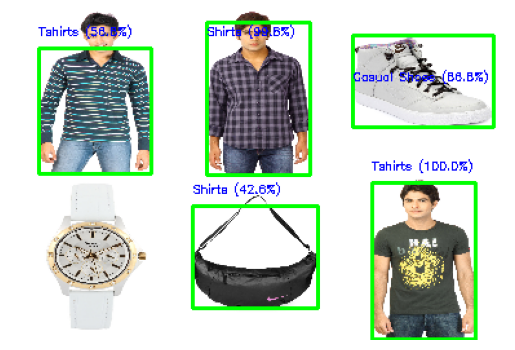

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


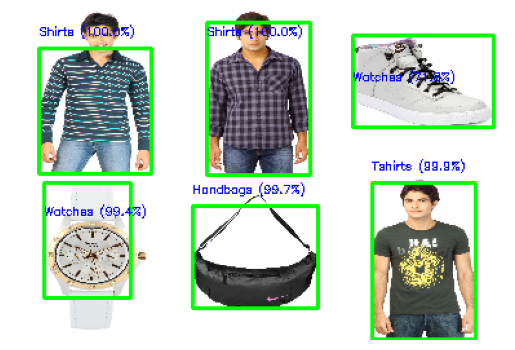

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


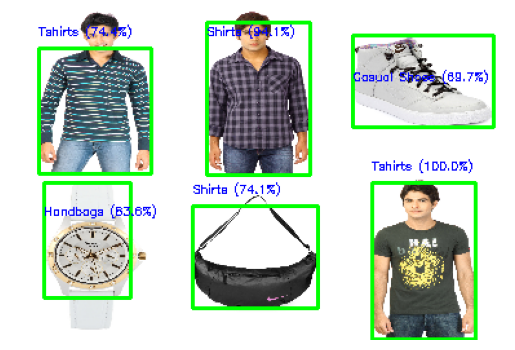

In [271]:

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from collections import Counter
from tensorflow.keras.utils import to_categorical
!pip install qgrid
import qgrid
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from google.colab import data_table
data_table.enable_dataframe_formatter()

# class StepHistory(Callback):
#     def on_train_begin(self, logs=None):
#         self.step_losses = []
#         self.step_acc = []

#     def on_train_batch_end(self, batch, logs=None):
#         self.step_losses.append(logs.get('loss'))
#         self.step_acc.append(logs.get('accuracy'))

# step_history = StepHistory()
# train,test=Divide_data_set(data.copy(), train, test)

# x_train=train[:,:3]
# y_train=train[:,3]
# x_test=test[:,:3]
# y_test=test[:,3]
# (x_train, y_train),(x_test, y_test)=mnist.load_data()
# (x_train, y_train),(x_test, y_test)=fashion_mnist.load_data()


# ------------------------------------------------------
# 1️⃣ Kaggle Dataset Download
# ------------------------------------------------------
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")
csv_path = os.path.join(path, "fashion-dataset", "styles.csv")
df = pd.read_csv(csv_path, on_bad_lines='skip')

# ------------------------------------------------------
# 2️⃣ Use only 'id' and 'articleType' columns + check paths
# ------------------------------------------------------
df = df[['id', 'articleType']].dropna()
df['image_path'] = df['id'].astype(str).apply(
    lambda x: os.path.join(path, 'fashion-dataset', 'images', f"{x}.jpg")
)
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

# ------------------------------------------------------
# 3️⃣ Target labels (4-class)
# ------------------------------------------------------
target_labels = ['Tshirts', 'Shirts', 'Casual Shoes','Watches','Handbags']
df = df[df['articleType'].isin(target_labels)].reset_index(drop=True)

# 클래스별 개수 확인
class_counts = df['articleType'].value_counts()
print("📊 클래스별 원본 개수:\n", class_counts)

# ------------------------------------------------------
# 4️⃣ 균형 맞추기 (클래스당 1700장씩)
# ------------------------------------------------------
max_num_class = 1700
balanced_dfs = []

for label in target_labels:
    subset = df[df['articleType'] == label]
    sample_size = min(len(subset), max_num_class)
    balanced_dfs.append(subset.sample(sample_size, random_state=42))

df_balanced = pd.concat(balanced_dfs).reset_index(drop=True)


# ------------------------------------------------------
# 5️⃣ 이미지 전처리 (64x64 RGB)
# ------------------------------------------------------
def preprocess_image(img_path, target_size=(64, 64)):
    img = load_img(img_path, target_size=target_size, color_mode='rgb')
    img_array = img_to_array(img) / 255.0
    return img_array

print("\n🔄 이미지 로드 중...")
x_data = np.array([preprocess_image(p) for p in df_balanced['image_path']])

le = LabelEncoder()
y_data = le.fit_transform(df_balanced['articleType'])
y_onehot = to_categorical(y_data)
class_names = list(le.classes_)

print("✅ 전처리 완료!")
print("클래스 이름:", class_names)
print("입력 데이터:", x_data.shape)

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot.argmax(axis=1)
)
print("\n📊 데이터 분할 완료:")
print("Train:", x_train.shape, " Test:", x_test.shape)
class_names= list(le.classes_)

# ✅ 🔽🔽🔽 여기에 추가 🔽🔽🔽
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#증강
# train_datagen = ImageDataGenerator(
#     rotation_range=5,
#     width_shift_range=0.05,
#     height_shift_range=0.05,
#     zoom_range=0.05,
#     horizontal_flip=True
# )

#증강 수치 2배
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train, batch_size=16, shuffle=True)
test_generator = test_datagen.flow(x_test, y_test, batch_size=16, shuffle=False)

# ----------------------------------------------------
# 7️⃣ CNN 모델 정의 (BatchNorm + Dropout + GlobalPooling)
# ----------------------------------------------------
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

# 🔹 콜백 정의
checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/ColabModels/best_mode2.h5",  # 저장 경로
    monitor="val_accuracy",    # 모니터할 지표 (val_loss도 가능)
    mode="max",                # 'max'는 값이 클수록 좋다는 뜻 (accuracy용)
    save_best_only=True,       # 가장 좋은 결과만 저장
    verbose=1
)
#증강 or 증강 x 모델
# model = keras.models.Sequential([
#     layers.Input(shape=(64,64,3)),
#     layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal'),
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Dropout(0.25),

#     layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal'),
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Dropout(0.25),

#     layers.Flatten(),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.4),

#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.4),
#     layers.Dense(5, activation='softmax')
# ])

#증강 수치 두배전용 모델
model =keras.models.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),

    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),

    keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(5, activation='softmax')
])

optimizer=keras.optimizers.Adam(learning_rate=0.0003)
model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=["accuracy"])

# # ✅ 학습 시에도 fit() 대신 generator 사용
# history = model.fit(
#     x_train, y_train,              # 입력 데이터와 라벨
#     validation_data=(x_test, y_test),
#     epochs=20,
#     callbacks=[checkpoint],
#     verbose=1
# )
history = model.fit(
    train_generator,                 # 학습용 generator
    validation_data=test_generator,  # 검증용 generator (← 여기가 핵심)
    epochs=20,
    # callbacks=[checkpoint],
    verbose=1
)


save_dir = "/content/drive/MyDrive/ColabModels"
os.makedirs(save_dir, exist_ok=True)
model.save("/content/fashion_cnn_last1.h5")
print("💾 모델 저장 완료: /content/fashion_cnn_last1.h5")
model_path = os.path.join(save_dir, "fashion_cnn_last1.h5")
model.save(model_path)

pd.DataFrame(history.history).plot()

plt.title("optimizer=Adam")
plt.xlabel("epoch")
plt.ylabel("loss,acc")
plt.grid(True)
plt.xticks(np.arange(0, 20,1))
plt.yticks(np.arange(0, 1.6, 0.1))
plt.gca().set_ylim(0,1.5)
plt.xlim(0,19)
plt.show()




# y_pred = model.predict(x_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_test, axis=1)


# cm = confusion_matrix(y_true, y_pred_classes)


# plt.figure(figsize=(10,8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names,
#             yticklabels=class_names)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix (Fashion)")
# plt.show()

# # step = 1875
# # #  Step 단위 그래프
# # plt.figure(figsize=(16,4))
# # plt.subplot(1,2,1)
# # plt.plot(step_history.step_losses,label="Loss")
# # plt.plot(step_history.step_acc,label="acc")
# # plt.title("Train Loss+Accuracy (per step)")
# # plt.gca().set_ylim(0,1.0)

# # plt.xlabel("Step")
# # plt.ylabel("Loss or Accuracy")
# # plt.legend()
# # plt.xticks(range(0, len(step_history.step_losses)+1, step))
# # plt.yticks(np.arange(0, 1.2, 0.1))
# # plt.grid(True)
# # plt.show()


# X_new= x_test[:5]
# Y_pred=np.argmax(model.predict(X_new),axis=1)
# print(Y_pred)

# plt.figure(figsize=(7,2))
# for index, image in enumerate(X_new):
#   plt.subplot(1,5,index+1)
#   plt.imshow(image)
#   plt.axis('off')
#   plt.title(class_names[Y_pred[index]],fontsize=12)

# plt.show()


# wrong_index_list=[]
# predict=model.predict(x_test)
# y_true = np.argmax(y_test, axis=1)
# y_pred = np.argmax(predict, axis=1)
# for index in range(len(y_true)):
#   if y_true[index] != y_pred[index]:
#     wrong_index_list.append(index)
# import random
# new_index=random.sample(wrong_index_list,5)
# wrong_X_new=x_test[new_index]

# plt.figure(figsize=(18,2))
# for index,image in enumerate(wrong_X_new):
#   plt.subplot(1,5,index+1)
#   plt.imshow(image)
#   plt.axis('off')

#   temp_Actial=class_names[y_true[new_index[index]]]
#   temp_Predict=class_names[y_pred[new_index[index]]]
#   title="Actial: {} Predict?: {}".format(temp_Actial,temp_Predict)
#   plt.title(title,fontsize=12)
# plt.show()


# 사용할 클래스 (이미 정의됨)

target_labels = ['Tshirts', 'Shirts', 'Casual Shoes','Watches','Handbags','Tshirts']

selected_imgs = []
for label in target_labels:
    subset = df_balanced[df_balanced['articleType'] == label]
    random_path = random.choice(subset['image_path'].tolist())
    img = cv2.imread(random_path)
    img = cv2.resize(img, (128, 128))
    selected_imgs.append(img)

# 2행 3열 (마지막 칸은 검정 이미지로 채우기)
empty_img = np.zeros_like(selected_imgs[0])  # 빈칸 채우기용
grid_imgs = selected_imgs + [empty_img]
rows = [np.hstack(grid_imgs[i:i+3]) for i in range(0, len(grid_imgs), 3)]
combined = np.vstack(rows[:2])  # 상하로 합치기

# BGR → RGB 변환 (OpenCV는 BGR이라 Matplotlib에서 색이 다름)
combined_rgb = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)


new_model=keras.models.load_model("/content/drive/MyDrive/ColabModels/best_model0.h5")
new_model.evaluate(x_test,y_test)


# img = cv2.imread('/content/img4.png')
img=combined_rgb

# plt.imshow(img)
# plt.axis('off')
# plt.show()


temp_img=img.copy()
# ------------------------------------------------------
# 📦 Selective Search + IoU NMS (개선버전)
# ------------------------------------------------------
_, regions = selectivesearch.selective_search(
    img,
    scale=300,     # 300 : 너무 세밀하지 않게
    sigma=0.8,     # 0.8 : 엣지 감지 완화
    min_size=1000  # 1000 : 너무 작은 박스 제거
)

region_rects = [cand['rect'] for cand in regions]

#===============================================
#수정전 버전
# region_rects= np.array(region_rects)
# bbox=[]
# bboxes=[]
# for rect in region_rects:
#   xmin=rect[0]
#   ymin=rect[1]
#   xmax=xmin+rect[2]
#   ymax=ymin+rect[3]
#   bbox=[(xmin,ymin,xmax,ymax)]
#   bboxes +=bbox
# bboxes =np.array(bboxes)

# for i,cands in enumerate(bboxes):
#   bb=cands
#   temp_img=cv2.rectangle(temp_img,(bb[0],bb[1]),(bb[2],bb[3]),color=(0,255,0),thickness=2)

# plt.imshow(temp_img)
# test_img=[]
# for i in range(len(bboxes)):
#   cropped_img=temp_img[bboxes[i][1]:bboxes[i][3],bboxes[i][0]:bboxes[i][2]]
#   warped_img=cv2.resize(cropped_img,(64,64),interpolation=cv2.INTER_LINEAR)
#   test_img.append(warped_img)

# plt.figure(figsize=(12, 4))
# for i in range(min(len(test_img), 10)):  # 상위 10장만 보기
#     plt.subplot(2, 5, i+1)
#     plt.imshow(test_img[i])
#     plt.axis('off')
# plt.show()

# for x in np.arange(3):
#   CNN_model=keras.models.load_model(f"/content/drive/MyDrive/ColabModels/best_model{x}.h5")
#   test_img=np.array(test_img)
#   y_pred_prob=CNN_model.predict(test_img)
#   y_pred=np.argmax(y_pred_prob,axis=1)
#   temp_img=img.copy()
#   used_positions = []  # 텍스트 겹침 방지용
#   temp_img = img.copy()  # 원본 이미지 복제

#   for (bb, pred, probs) in zip(bboxes, y_pred, y_pred_prob):
#       bb = np.array(bb).astype(int)
#       xmin, ymin, xmax, ymax = bb

#       # 확률 내림차순으로 정렬 → Top-2 추출
#       top_indices = probs.argsort()[-2:][::-1]
#       top_labels = [(class_names[i], probs[i]) for i in top_indices]

#       # 1️⃣ 가장 높은 클래스
#       label1, conf1 = top_labels[0]


#       # 색상 결정
#       if conf1 >= 0.6:
#           color = (0, 255, 0)       # 확신 있음: 초록
#           text_color = (255, 0, 0)  # 빨강 글씨

#           # 박스 그리기
#           cv2.rectangle(temp_img, (xmin, ymin), (xmax, ymax), color, 2)

#           # 텍스트 준비
#           text1 = f"{label1} ({conf1*100:.1f}%)"


#           # 텍스트 좌표 (겹침 방지)
#           text_x, text_y = xmin, max(ymin - 10, 20)
#           for (ux, uy) in used_positions:
#               if abs(text_x - ux) < 120 and abs(text_y - uy) < 25:
#                   text_y += 35
#           used_positions.append((text_x, text_y))


#           cv2.putText(temp_img, text1, (text_x, text_y),
#                       cv2.FONT_HERSHEY_SIMPLEX, 0.3, text_color, 1)




#   plt.imshow(temp_img)
#   plt.axis('off')
#   plt.show()









#=========================================================
#수정후 버전
# 면적 기준 상위 10개만
region_rects = sorted(region_rects, key=lambda x: x[2]*x[3], reverse=True)


H, W = temp_img.shape[:2]
bboxes = []
for (x, y, w, h) in region_rects:
    area_ratio = (w * h) / (W * H)
    # 1️⃣ 너무 작은 영역 제외
    if w < 20 or h < 20:
        continue

    # 2️⃣ 이미지 전체에 가까운 박스 제외
    if w > 0.9 * W and h > 0.9 * H:
        continue

    # 3️⃣ 비정상적으로 큰 영역 제외
    if area_ratio > 0.6:
        continue

    # ✅ 통과한 박스만 추가
    bboxes.append((x, y, x + w, y + h))
bboxes = np.array(bboxes)

# --- IoU 계산 ---
def iou(box1, box2):
    # 1️⃣ 교집합 영역의 좌표 계산
    x1, y1 = max(box1[0], box2[0]), max(box1[1], box2[1])   # 교집합 왼쪽 위
    x2, y2 = min(box1[2], box2[2]), min(box1[3], box2[3])   # 교집합 오른쪽 아래

    # 2️⃣ 교집합 면적 계산
    inter = max(0, x2 - x1) * max(0, y2 - y1)
    if inter == 0:
        return 0   # 겹치지 않으면 IoU = 0

    # 3️⃣ 각 박스의 면적 계산
    area1 = (box1[2]-box1[0]) * (box1[3]-box1[1])
    area2 = (box2[2]-box2[0]) * (box2[3]-box2[1])

    # 4️⃣ 합집합 면적 = 면적1 + 면적2 - 교집합
    # 5️⃣ IoU 계산
    return inter / (area1 + area2 - inter)

# --- NMS (중복 박스 제거) ---
filtered_boxes = []
for bb in bboxes:
    keep = True                     # 일단 유지한다고 가정
    for fb in filtered_boxes:       # 이미 선택된 박스들과 비교
        if iou(bb, fb) >= 0.4:      # 만약 겹침이 0.4 이상이면
            keep = False            # 이 박스는 버림
            break                   # 하나라도 겹치면 바로 중단
    if keep:
        filtered_boxes.append(bb)   # 겹치지 않으면 박스 추가

# 면적 기준 상위 4개만 유지
filtered_boxes = sorted(filtered_boxes, key=lambda b: (b[2]-b[0])*(b[3]-b[1]), reverse=True)[:10]
bboxes = np.array(filtered_boxes)

# ------------------------------------------------------
# ✂️ Crop & 예측
# ------------------------------------------------------
test_img = []
for bb in bboxes:
    xmin, ymin, xmax, ymax = bb
    crop = img[ymin:ymax, xmin:xmax]   # ✅ 원본 img 사용!
    if crop.shape[0] < 10 or crop.shape[1] < 10:
        continue
    crop = cv2.resize(crop, (64,64)).astype('float32')/255.0
    test_img.append(crop)
test_img = np.array(test_img)

for x in np.arange(3):
  CNN_model=keras.models.load_model(f"/content/drive/MyDrive/ColabModels/best_model{x}.h5")

  # 예측
  y_pred_prob = CNN_model.predict(test_img)
  y_pred = np.argmax(y_pred_prob, axis=1)

  # ------------------------------------------------------
  # 🏷️ 시각화 (라벨 겹침 방지 개선)
  # ------------------------------------------------------

  used_positions = []  # 텍스트 겹침 방지용
  temp_img = img.copy()  # 원본 이미지 복제
  for (bb, pred, probs) in zip(bboxes, y_pred, y_pred_prob):
      bb = np.array(bb).astype(int)
      xmin, ymin, xmax, ymax = bb


      top_idx = np.argmax(probs)
      label = class_names[top_idx]
      conf = probs[top_idx]  # 확률 값 (0~1)

      # 색상 결정
      if conf >= 0.3:
          color = (0, 255, 0)       # 확신 있음: 초록
          text_color = (0, 0, 255)  # 빨강 글씨

          # 박스 그리기
          cv2.rectangle(temp_img, (xmin, ymin), (xmax, ymax), color, 2)

          # 텍스트 준비
          text = f"{label} ({conf*100:.1f}%)"


          # 텍스트 좌표 (겹침 방지)
          text_x, text_y = xmin, max(ymin - 10, 20)
          for (ux, uy) in used_positions:
              if abs(text_x - ux) < 120 and abs(text_y - uy) < 25:
                  text_y += 35
          used_positions.append((text_x, text_y))


          cv2.putText(temp_img, text, (text_x, text_y),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.3, text_color, 1)




  plt.imshow(temp_img)
  plt.axis('off')
  plt.show()



# 새 섹션